In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import pandas as pd

# Parse FiveThirtyEight data

Source: https://fivethirtyeight.com/features/the-big-picture-in-the-race-for-the-house/ (Table -- "The odds for all 435 house races"). Current as of 8/16/18. 

In [2]:

def convert_to_float(x):
    if x == '>99%':
        return 99.
    if x == '<1%':
        return 1.
    return round(float(x.replace('%', '')), 3)

f = open('fivethirtyeight_original_data.txt')
combined_data = []
for line in f:
    l = line.split()
    name = ' '.join(l[1:-2])
    district = l[0]
    district_state, district_number = district.split('-')
    if len(district_number) == 1: # missing a zero. Need to add to join to Cook. 
        district_number = '0' + district_number
    district = district_state + '-' + district_number
    republican_wins  = convert_to_float(l[-1]) 
    dem_wins = convert_to_float(l[-2]) 
    assert abs(100 - republican_wins - dem_wins) <= 1
    combined_data.append({'538_democrat_wins':dem_wins, 
                          '538_diff_from_even':round(abs(50 - dem_wins), 3),
                          'name':name,
                          'district':district})
    


combined_data = pd.DataFrame(combined_data)[['district',
                                             'name',
                                             '538_democrat_wins',
                                             '538_diff_from_even']].sort_values(by='538_diff_from_even')

                                                                   


# Parse Cook data
Source: https://www.cookpolitical.com/ratings/house-race-ratings. 
Current as of Aug 17, 2018. 

In [3]:
def convert_pvi_rating_to_float(x):
    if x[:2] == 'R+':
        x = -float(x.replace('R+', ''))
    elif x[:2] == 'D+':
        x = float(x.replace('D+', ''))
    elif x == 'EVEN':
        x = 0.
    elif x == 'UNKNOWN':
        x = None
    else:
        raise Exception("%s is not a valid value" % x)
    return x
    
f = open('cook_original_data.txt')
cook_districts_to_info = {}
for line in f:
    l = line.split()
    if len(l) == 1:
        cook_category = l[0]
        assert [cook_category in ['SOLID_REPUBLICAN', 
                                  'SOLID_DEMOCRATIC', 
                                  'LIKELY_DEMOCRATIC', 
                                  'LEAN_DEMOCRATIC', 
                                  'TOSS_UP_DEMOCRATIC', 
                                  'TOSS_UP_REPUBLICAN', 
                                  'LEAN_REPUBLICAN', 
                                  'LIKELY_REPUBLICAN']]
    else:
        name = ' '.join(l[1:-1])
        if name == 'Open': # change "open" to "open seat" for consistency with FiveThirtyEight. 
            name = name + ' seat'
        district = l[0]
        if district.split('-')[1] == '00': # rename districts from 00 to 01 for consistency with FiveThirtyEight. 
            district = district.replace('00', '01')
        pvi_rating = convert_pvi_rating_to_float(l[-1])
        assert district not in cook_districts_to_info
        cook_districts_to_info[district] = {'cook_name':name, 
                                                   'cook_pvi_rating':pvi_rating, 
                                                   'cook_category':cook_category}
                                                   
for k in ['cook_name', 'cook_pvi_rating', 'cook_category']:
    combined_data[k] = combined_data['district'].map(lambda x:cook_districts_to_info[x][k])

# A couple basic sanity checks

In [4]:
assert len(combined_data) == 435

# a bunch of names don't match between Cook + 538 data but this appears to be for 
# largely innocuous reasons -- differences in the spelling of the same name. 
# Let me know if you notice significant errors. 

names_not_equal = combined_data['cook_name'] != combined_data['name']
print 'warning: %i/%i names did not match' % (names_not_equal.sum(), len(names_not_equal))
print combined_data.loc[names_not_equal, ['cook_name', 'name']].to_string()



               cook_name                       name
407           David Brat                  Dave Brat
141         Peter Roskam            Peter J. Roskam
297        Chris Collins                  Open seat
272           Peter King                  Pete King
218      Collin Peterson         Collin C. Peterson
330               Vacant                  Open seat
70         Duncan Hunter           Duncan D. Hunter
340        Keith Rothfus                 Conor Lamb
255    Christopher Smith                Chris Smith
331   Matthew Cartwright            Matt Cartwright
12        Tom O'Halleran             Tom O’Halleran
119         Karen Handel            Karen C. Handel
77             Open seat                   Ken Buck
370       Michael McCaul          Michael T. McCaul
427    Jim Sensenbrenner     F. James Sensenbrenner
288         Sean Maloney       Sean Patrick Maloney
98         Gus Bilirakis           Gus M. Bilirakis
401       Robert Wittman          Robert J. Wittman
187         

# Basic analysis

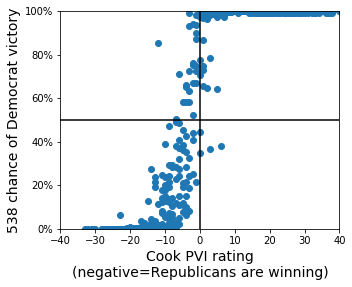

Average values of 538_democrat_wins by Cook category
                         mean  size
cook_category                      
SOLID_REPUBLICAN     2.528889   153
LIKELY_REPUBLICAN   21.160800    25
LEAN_REPUBLICAN     26.491538    26
TOSS_UP_DEMOCRATIC  40.390000     2
TOSS_UP_REPUBLICAN  51.537778    27
LEAN_DEMOCRATIC     81.214444     9
LIKELY_DEMOCRATIC   94.101667    12
SOLID_DEMOCRATIC    99.495801   181
Average values of cook_pvi_rating by Cook category
                         mean  size
cook_category                      
SOLID_REPUBLICAN   -15.875817   153
LIKELY_REPUBLICAN   -6.840000    25
LEAN_REPUBLICAN     -6.160000    26
TOSS_UP_DEMOCRATIC  -4.500000     2
TOSS_UP_REPUBLICAN  -3.111111    27
LEAN_DEMOCRATIC     -0.555556     9
LIKELY_DEMOCRATIC    1.000000    12
SOLID_DEMOCRATIC    16.823204   181


In [5]:
import matplotlib.pyplot as plt

# make a plot of Cook PVI rating vs 538's probability democrat wins. Concordance is reasonable. 
fontsize=14
plt.figure(figsize=[5, 4])
plt.scatter(combined_data['cook_pvi_rating'], 
            combined_data['538_democrat_wins'])
plt.xlabel("Cook PVI rating\n(negative=Republicans are winning)", fontsize=fontsize)
plt.ylabel("538 chance of Democrat victory", fontsize=fontsize)
plt.plot([0, 0], [0, 100], color='black')
plt.plot([-40, 40], [50, 50], color='black')
plt.yticks([0, 20, 40, 60, 80, 100], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.xlim([-40, 40])
plt.ylim([0, 100])
plt.show()
                                     
                                    
for k in ['538_democrat_wins', 
          'cook_pvi_rating']:
    grouped_d = combined_data[[k, 'cook_category']].groupby('cook_category').agg(['mean', 'size'])
    grouped_d.columns = ['mean', 'size']
    print 'Average values of %s by Cook category' % k
    print grouped_d.sort_values(by='mean')


# Print out all data sorted by FiveThirtyEight's probability that the Democrat wins. 

Here's what the columns mean in the table below: 
- district: the name of the district
- name: 538's name for the incumbent
- 538_democrat_wins: the percentage chance the Democrat wins, according to the FiveThirtyEight model (0 - 100).
- 538_diff_from_even: the absolute difference between 538_democrat_wins and 50. Table is sorted by this column.
- cook_name: Cook's name -- just used this so people can see if something went wrong with the data parsing. 
- cook_pvi_rating: Cook's PVI rating -- negative values indicate Republican is winning. 
- cook_category -- the category Cook puts the race in



In [6]:
pd.set_option('max_rows', 500)
combined_data.to_csv('combined_data.csv', index=False)
combined_data.sort_values(by='538_diff_from_even')


,district,name,538_democrat_wins,538_diff_from_even,cook_name,cook_pvi_rating,cook_category
241,NC-09,Open seat,50.35,0.35,Open seat,-7.0,TOSS_UP_REPUBLICAN
367,TX-07,John Culberson,49.32,0.68,John Culberson,-7.0,TOSS_UP_REPUBLICAN
309,OH-12,Troy Balderson,48.95,1.05,Troy Balderson,-7.0,LEAN_REPUBLICAN
405,VA-05,Open seat,48.78,1.22,Open seat,-6.0,LEAN_REPUBLICAN
289,NY-19,John Faso,52.13,2.13,John Faso,-2.0,TOSS_UP_REPUBLICAN
172,KY-06,Andy Barr,47.30,2.70,Andy Barr,-9.0,TOSS_UP_REPUBLICAN
212,MN-01,Open seat,45.34,4.66,Open seat,-5.0,TOSS_UP_DEMOCRATIC
420,WA-08,Open seat,44.36,5.64,Open seat,0.0,TOSS_UP_REPUBLICAN
254,NJ-03,Tom MacArthur,43.91,6.09,Tom MacArthur,-2.0,TOSS_UP_REPUBLICAN
205,MI-08,Mike Bishop,42.62,7.38,Mike Bishop,-4.0,TOSS_UP_REPUBLICAN
